# Código Python - Trabalho 2

## *Imports* estáticos

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

## 4.1  Análise Exploratória de Dados
### 4.1.1   Leitura do ficheiro

In [3]:
dados = pd.read_csv('dados/AIRPOL_data.csv', delimiter=";", header=0, decimal=',')
dados = dados.drop(columns=['Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15'])
#dados = dados[dados.Country != 'All Countries']
#dados.sort_values(by=['Value'])

#### Sumário dos dados

In [4]:
print(dados.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49140 entries, 0 to 49139
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Country                       49140 non-null  object 
 1   NUTS_Code                     49140 non-null  object 
 2   Air_Pollutant                 49140 non-null  object 
 3   Outcome                       49140 non-null  object 
 4   Affected_Population           49140 non-null  float64
 5   Populated_Area[km2]           49140 non-null  float64
 6   Air_Pollution_Average[ug/m3]  49140 non-null  float64
 7   Value                         49140 non-null  float64
dtypes: float64(4), object(4)
memory usage: 3.0+ MB
None


### 4.1.2   Exploração com gráficos

In [5]:
dados.describe()

,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value
count,4.914000e+04,4.914000e+04,49140.000000,49140.000000
mean,1.023692e+06,6.534426e+03,15.138166,366.798657
std,9.085726e+06,5.661679e+04,22.579360,5494.481929
min,2.674000e+03,2.000000e+00,0.100000,0.000000
25%,1.069040e+05,5.697000e+02,7.200000,3.000000
50%,2.388280e+05,1.340100e+03,8.900000,23.000000
75%,5.988800e+05,4.215200e+03,11.400000,112.000000
max,4.680626e+08,2.687568e+06,125.700000,740933.000000


In [6]:
features = list(dados.columns[0:8])
print(features)

['Country', 'NUTS_Code', 'Air_Pollutant', 'Outcome', 'Affected_Population', 'Populated_Area[km2]', 'Air_Pollution_Average[ug/m3]', 'Value']


In [7]:
numericFeatures = features[4:]
numericFeatures

['Affected_Population',
 'Populated_Area[km2]',
 'Air_Pollution_Average[ug/m3]',
 'Value']

#### Análise Univariável

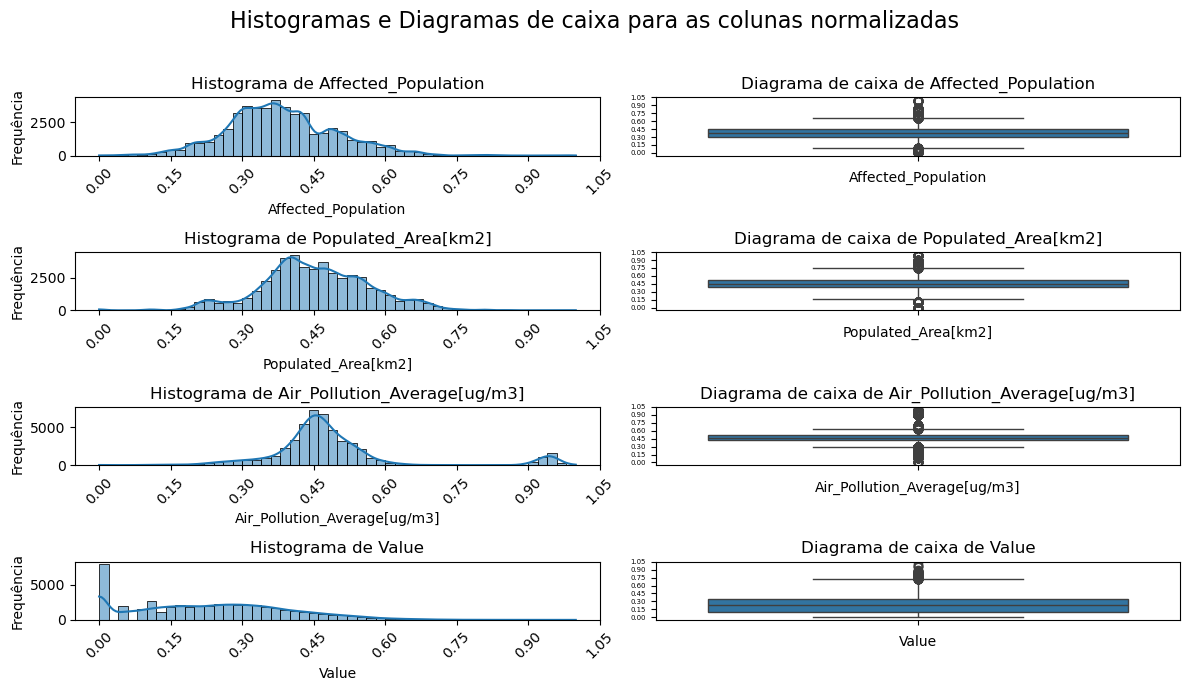

In [8]:
# Aplicar log1p (log(1 + x)) para reduzir o impacto de valores extremos
dados_log = dados[numericFeatures].apply(lambda x: np.log1p(x))

# Aplicar MinMaxScaler
scaler = MinMaxScaler()
dados_scaled = pd.DataFrame(scaler.fit_transform(dados_log), columns=numericFeatures)

num_features = len(numericFeatures)
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(12, 3 + num_features))
fig.suptitle("Histogramas e Diagramas de caixa para as colunas normalizadas", fontsize=16)

for i, column in enumerate(numericFeatures):

    sns.histplot(dados_scaled[column], ax=axes[i, 0], kde=True, bins=50)
    axes[i, 0].set_title(f"Histograma de {column}")
    axes[i, 0].set_xlabel(column)
    axes[i, 0].set_ylabel("Frequência")
    axes[i, 0].tick_params(axis='x', labelrotation=45)
    axes[i, 0].xaxis.set_major_locator(plt.MaxNLocator(10))

    sns.boxplot(y=dados_scaled[column], ax=axes[i, 1])
    axes[i, 1].set_title(f"Diagrama de caixa de {column}")
    axes[i, 1].set_xlabel(column)
    axes[i, 1].set_ylabel("")
    axes[i, 1].tick_params(axis='y', labelsize=5)
    axes[i, 1].yaxis.set_major_locator(plt.MaxNLocator(10))

plt.tight_layout(rect=(0, 0, 1, 0.96))
plt.show()

#### Análise Bivariável

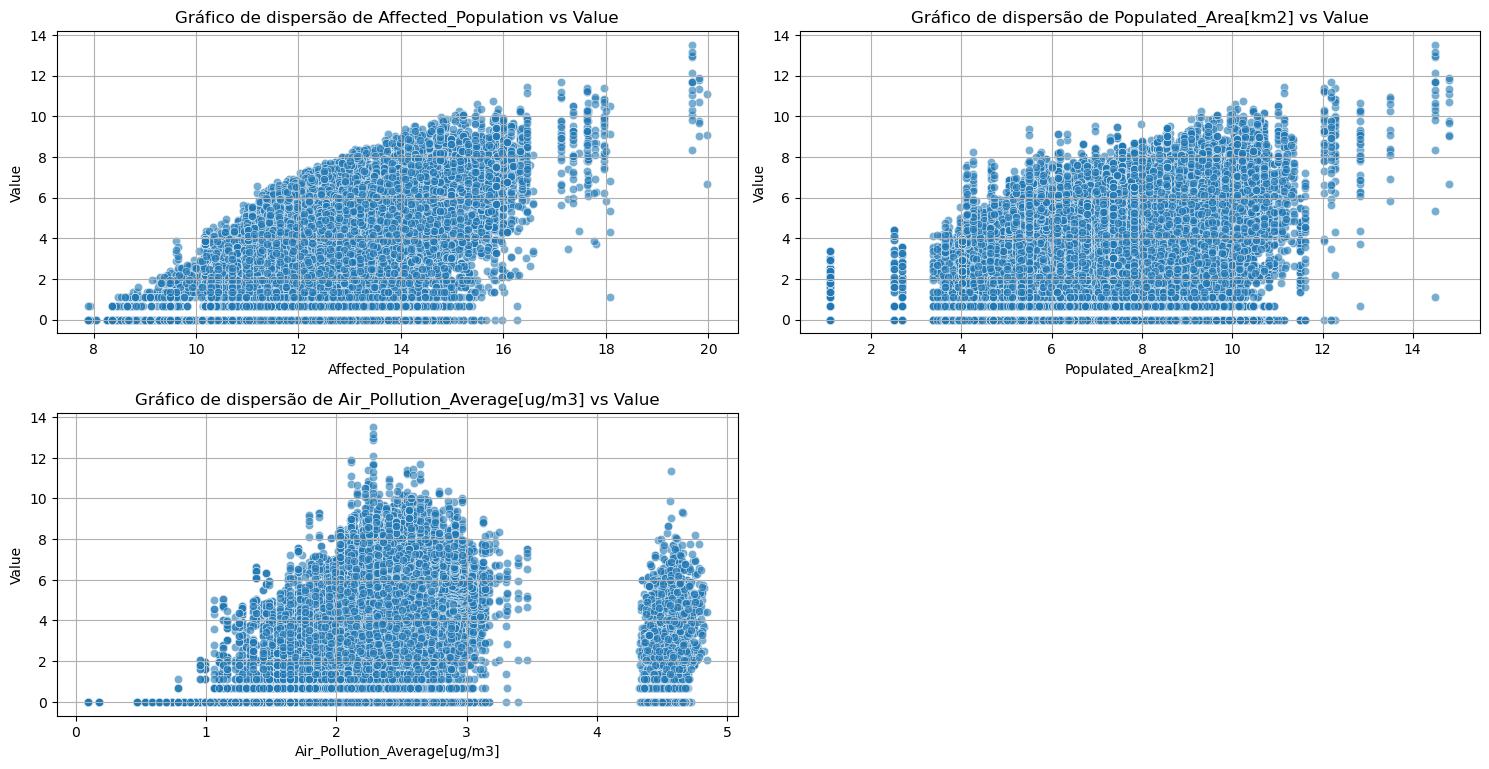

In [9]:
goalAttrib = 'Value'

plt.figure(figsize=(15,15))
numericFeaturesWOValue = [f for f in numericFeatures if f != goalAttrib]
for i, feature in enumerate(numericFeaturesWOValue):
    rows = (len(numericFeaturesWOValue) + 1) # Adjust rows to handle odd number of features
    plt.subplot(rows,2,i+1)
    sns.scatterplot(x=dados_log[feature], y=dados_log[goalAttrib], alpha=0.6)
    plt.title("Gráfico de dispersão de " + feature + " vs " + goalAttrib)
    plt.xlabel(feature)
    plt.ylabel(goalAttrib)
    plt.grid()
plt.tight_layout()

In [10]:
# Que mais?

### 4.1.3. Pré-processamento dos dados

In [11]:
# Remover outliers
print(f"Número de linhas antes da remoção de outliers: {len(dados)}")

for col in numericFeatures:
    Q1 = dados[col].quantile(0.25)
    Q3 = dados[col].quantile(0.75)
    IQR = Q3 - Q1
    filtro = (dados[col] >= (Q1 - 1.5 * IQR)) & (dados[col] <= (Q3 + 1.5 * IQR))
    dados = dados[filtro]

print(f"Número de linhas após remoção de outliers: {len(dados)}")

Número de linhas antes da remoção de outliers: 49140
Número de linhas após remoção de outliers: 30917


### 4.1.4. Agrupamento dos dados em zonas

In [12]:
westEuDados = dados[dados['Country'].isin(['Austria', 'Belgium', 'France', 'Germany', 'Netherlands', 'Switzerland'])]
eastEuDados = dados[dados['Country'].isin(['Poland', 'Czechia', 'Hungary'])]
soutEuDados = dados[dados['Country'].isin(['Greece', 'Spain', 'Italy', 'Portugal'])]
nortEuDados = dados[dados['Country'].isin(['Sweden', 'Denmark', 'Northern Europe', 'Finland'])]

### 4.2.2 - Com o método k-fold cross validation obter um modelo de regressão linear simples para a variável Premature_Deaths usando a variável Affected_Population dos países do Southern Europe

In [13]:
goalAttr = soutEuDados.columns[7]
feature = soutEuDados.columns[4]

print(f"Goal attribute: {goalAttr}")
print(f"Feature: {feature}")

Goal attribute: Value
Feature: Affected_Population


#### Divisão dos dados (Holdout stratied: 80% Train / 20% Test)

In [14]:
from sklearn.model_selection import train_test_split

y = soutEuDados[goalAttr]
X = soutEuDados[feature]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('Train set size: ' + str(X_train.shape) + "x_test_size" + str(X_test.shape))
print('Test set size: ' + str(y_train.shape) + "y_test_size" + str(y_test.shape))

Train set size: (4532,)x_test_size(1134,)
Test set size: (4532,)y_test_size(1134,)


#### K-Fold Cross Validation

In [15]:
from sklearn.model_selection import KFold

def split_into_k_folds(data, k):

    kf = KFold(n_splits=k, shuffle=True)

    folds = []
    for train_index, test_index in kf.split(data):
        folds.append((train_index, test_index))
    
    return folds

In [16]:
K=10
kFolds = split_into_k_folds(X_train, K)
for train_idx, test_idx in kFolds:
    print({len(train_idx), len(test_idx)})
    print(train_idx)
    print(test_idx)

{454, 4078}
[   0    1    2 ... 4529 4530 4531]
[  10   13   22   32   44   46   62   72   93   99  101  117  132  182
  201  210  215  225  227  231  243  257  262  263  271  275  278  284
  286  292  302  312  326  328  343  350  351  357  371  395  414  417
  426  433  438  450  463  489  494  513  519  522  554  567  572  573
  575  615  619  628  646  654  671  675  682  683  689  690  701  703
  705  708  723  739  744  787  799  830  833  838  860  873  874  883
  887  911  914  917  923  929  935  939  947  957  963  972  980  988
  991  995 1002 1010 1011 1086 1090 1115 1117 1118 1126 1133 1137 1141
 1150 1152 1153 1161 1162 1164 1167 1177 1178 1179 1187 1188 1192 1201
 1214 1222 1234 1275 1304 1320 1333 1343 1344 1346 1347 1376 1377 1395
 1402 1412 1421 1430 1485 1490 1504 1512 1513 1518 1533 1545 1552 1556
 1573 1582 1587 1589 1601 1606 1616 1617 1649 1668 1671 1677 1679 1683
 1688 1689 1692 1696 1713 1718 1719 1722 1752 1782 1783 1784 1785 1822
 1829 1838 1858 1862 1874 193

In [17]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

coefs = []
intercepts = []

for train_idx, test_idx in kFolds:
    X_train_fold = X_train.iloc[train_idx].to_frame()
    y_train_fold = y_train.iloc[train_idx]
    lr.fit(X_train_fold, y_train_fold)
    coefs.append(lr.coef_[0])
    intercepts.append(lr.intercept_)

coef_mean = np.mean(coefs)
coef_std = np.std(coefs)
intercept_mean = np.mean(intercepts)
intercept_std = np.std(intercepts)

print(f"Função linear média: {goalAttr} = ({np.round(coef_mean, 6)} ± {np.round(coef_std, 6)}) * {feature} + ({np.round(intercept_mean, 3)} ± {np.round(intercept_std, 3)})")

Função linear média: Value = (5.4e-05 ± 1e-06) * Affected_Population + (16.44 ± 0.188)


#### Visualização da reta e da dispersão dos dados

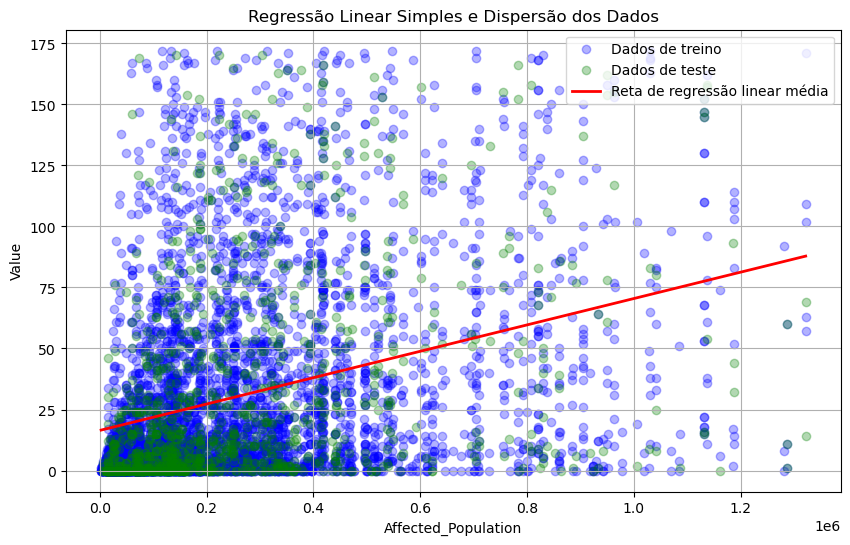

In [18]:
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, color='blue', alpha=0.3, label='Dados de treino')
plt.scatter(X_test, y_test, color='green', alpha=0.3, label='Dados de teste')
x_vals = np.linspace(X.min(), X.max(), 100)
y_vals = coef_mean * x_vals + intercept_mean
plt.plot(x_vals, y_vals, color='red', linewidth=2, label='Reta de regressão linear média')
plt.xlabel(feature)
plt.ylabel(goalAttr)
plt.title('Regressão Linear Simples e Dispersão dos Dados')
plt.legend()
plt.grid(True)
plt.show()

#### Calcular o MAE (Mean Absolute Error) e o RMSE (Round Mean Squared Error)

In [19]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Previsão nos dados de teste
y_pred_test = coef_mean * X_test + intercept_mean

# Calcular MAE e RMSE
mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print(f"MAE: {np.round(mae, 3)}")
print(f"RMSE: {np.round(rmse, 3)}")

MAE: 28.534
RMSE: 38.259
